In [2]:
import sys
import numpy as np 
import pandas as pd 
sys.path.append('..')
import seaborn as sns
import matplotlib.cm as cm
from src.datasets import HMDA 
import matplotlib.pyplot as plt
from src.proxies import gBisg, mlBisg
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

In [3]:
import matplotlib.pyplot as plt 
from src.datasets import HMDA
from src.proxies import gBisg, mlBisg

gbisg = gBisg()
races = ["white", "black", "hispanic", "api"]
hmda = HMDA("../data/hmda/state_MD-PA-NY-DE-VA.csv", 
            outcome=True, 
            include_geo=True, 
            geo="tract", 
            proxy=gbisg,
            races=races)

X_train, X_test, Y_train, Y_test, B_train, B_test = hmda.get_data(split=.7, return_bisg=True)


/Users/kaggrey/Documents/research/proxies/experiments/../src/proxies.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probs_new["other"] = probs.iloc[:,excl_indexes].sum(axis=1, min_count=1)


In [4]:
X_train.shape

(437850, 26)

In [83]:
X_train.columns

Index(['loan_amount', 'income', '(Denied) Debt-To-Income',
       '(Denied) Employment History', '(Denied) Credit History Denial',
       '(Denied) Collateral', '(Denied) Insufficient Funds',
       '(Denied) Unverifiable', '(Denied) Credit App Incomplete',
       '(Denied) Insurance Denied', '(Denied) Other', 'Not Denied',
       'Not Specified', 'Loan Originated', 'Loan Appr (only)', 'Loan Denied',
       'App. Withdraw', 'Incomplete', 'Puchased Loan', 'Pre-Appr. Denied',
       'Pre-Appr (Only)', 'white', 'black', 'hispanic', 'api', 'other'],
      dtype='object')

In [84]:
from sklearn.calibration import calibration_curve
mlbisg = mlBisg(model="mr", proxy=None)
mlbisg.train(X_train, Y_train)
predicted = mlbisg.inference(X_test)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [85]:
def calibration_curve_size(y_true, y_prob, n_bins=5):

    bins = np.linspace(0.0, 1.0, n_bins + 1)

    binids = np.searchsorted(bins[1:-1], y_prob)

    bin_sums = np.bincount(binids, weights=y_prob, minlength=len(bins))
    bin_true = np.bincount(binids, weights=y_true, minlength=len(bins))
    bin_total = np.bincount(binids, minlength=len(bins))

    nonzero = bin_total != 0
    prob_true = bin_true[nonzero] / bin_total[nonzero]
    prob_pred = bin_sums[nonzero] / bin_total[nonzero]

    bin_prop = bin_total/bin_total.sum()
    return prob_true, prob_pred, bin_total

In [86]:
n_bins = 8
bins = np.linspace(0,1, n_bins+1)
B = B_test.to_numpy() 
Y = Y_test.to_numpy()


all_results = [] 
race_ixes = [0,1, 2,3]

for r in race_ixes:
    prob_true, prob_pred, prop_size = calibration_curve_size(
        y_true=(Y == r).flatten().astype(int), 
        y_prob=B[:,r], 
        n_bins=10
    )


    results = [] 
    for i in range(prob_true.size):
        results.append({
            "True Prop.": prob_pred[i], 
            "error": np.abs(prob_pred[i] - prob_true[i]), 
            "size": prop_size[i], 
            "method": "BISG",
            "race": races[r]
        })

    prob_true, prob_pred, prop_size = calibration_curve_size(
        y_true=(Y == r).flatten().astype(int), 
        y_prob=predicted[:,r], 
        n_bins=n_bins
    )

    for i in range(prob_true.size):
        results.append({
            "True Prop.": prob_pred[i], 
            "error": np.abs(prob_pred[i] - prob_true[i]), 
            "size": prop_size[i], 
            "method": "MICSG(MR)",
            "race": races[r]
        })

    r_df = pd.DataFrame(results)
    all_results.append(r_df)




/var/folders/6j/97pkxkbn20zdxwjg13tprrb00000gq/T/ipykernel_28725/2446620871.py:20: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  curr_ax = sns.scatterplot(
/var/folders/6j/97pkxkbn20zdxwjg13tprrb00000gq/T/ipykernel_28725/2446620871.py:29: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  curr_ax = sns.lineplot(
/var/folders/6j/97pkxkbn20zdxwjg13tprrb00000gq/T/ipykernel_28725/2446620871.py:20: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  curr_ax = sns.scatterplot(
/var/folders/6j/97pkxkbn20zdxwjg13tprrb00000gq/T/ipykernel_28725/2446620871.py:29: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  curr_ax = sns.lineplot(
/var/folders/6j/97pkxkbn20zdxwjg13tprrb00000gq/T/ipykernel_28725/2446620871.py:20: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  cur

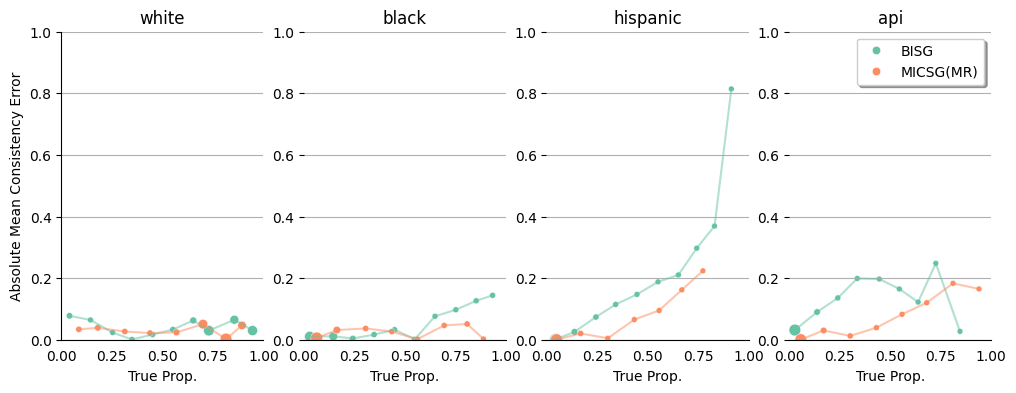

In [88]:
df = pd.concat(all_results, axis=0)
# g = sns.FacetGrid(data=df, col="race", palette=sns.color_palette("Paired"), sharey=True)
# g.map(sns.scatterplot, "pred", "error", "method", "size")
# g.add_legend()
# sns.despine(left=True, bottom=True)
# print(len(g.axes[0]))
# for i,x in enumerate(g.axes[0]):
#     x.axhline(y = -0.003, color = 'black', alpha=0.25, linestyle = '--') 
#     x.set_title(races[i])

race_ixes = [0,1, 2,3]
fig, axs = plt.subplots(1, len(race_ixes), figsize=(12,4))

axs[0].set_ylabel("Absolute Mean Consistency Error")
# axs[1].set_xlabel("Predicted")

for i, index in enumerate(race_ixes):
  
    
    curr_ax = sns.scatterplot(
        data = all_results[i],
        y = "error",
        x = "True Prop.",
        hue = "method",
        size = "size", 
        ax = axs[i],
        palette=sns.color_palette("Set2"),
    )
    curr_ax = sns.lineplot(
        data = all_results[i],
        y = "error",
        x = "True Prop.",
        hue = "method",
        # size = "size", 
        ax = axs[i],
        alpha=0.5, 
        palette=sns.color_palette("Set2"),
    )
    axs[i].get_legend().remove()
    # axs[i].axhline(y = -0.003, color = 'black', alpha=0.25, linestyle = '--') 
    axs[i].grid(axis = 'y')
    axs[i].set_title(races[i])
    if i != 0:
        axs[i].set_ylabel("")
        axs[i].xaxis.set_ticks_position('none') 
        axs[i].spines[['right', 'left', "top"]].set_visible(False)




    axs[i].set_xlim(0,1)
    axs[i].set_ylim(0,1)
    axs[i].xaxis.set_ticks_position('none') 

    axs[i].spines[['right', 'top']].set_visible(False)


h, l = curr_ax.get_legend_handles_labels()

# slice the appropriate section of l and h to include in the legend
plt.legend(h[1:3], l[1:3], fancybox=True, shadow=True)
# plt.legend()
plt.show()

    

In [91]:

mask = X_test["Loan Originated"]
disp_result = []


for i in range(len(races)):

    real_rate = X_test[Y_test.to_numpy() == i]["Loan Originated"].mean()

    disp_result.append({
        "race": B_test.columns[i],
        "prop.": real_rate,
        "method": "HMDA"
    })

    bisg_rate = ((B_test * X_test["Loan Originated"].to_numpy()[:, np.newaxis]).mean(axis=0)/B_test.mean())[i]

    disp_result.append({
        "race": B_test.columns[i],
        "prop.": bisg_rate,
        "method": "BISG"
    })

    

for method in ["mr", "gb"]:
    mlbisg = mlBisg(model=method, proxy=None)
    mlbisg.train(X_train, Y_train)
    predicted = mlbisg.inference(X_test)

    for i in range(len(races)):
        p = predicted[mask].mean(axis=0)
        top = (p[i] * X_test["Loan Originated"].mean()) 
        bottom = predicted.mean(axis=0)[i]
        our_rate = top/bottom

        disp_result.append({
            "race": B_test.columns[i],
            "prop.": our_rate,
            "method": "MICSG+" + method.upper()
        })



disp_df = pd.DataFrame(disp_result)



/var/folders/6j/97pkxkbn20zdxwjg13tprrb00000gq/T/ipykernel_28725/1419619854.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bisg_rate = ((B_test * X_test["Loan Originated"].to_numpy()[:, np.newaxis]).mean(axis=0)/B_test.mean())[i]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11

/var/folders/6j/97pkxkbn20zdxwjg13tprrb00000gq/T/ipykernel_28725/3720648016.py:2: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  g = sns.stripplot(data=disp_df,


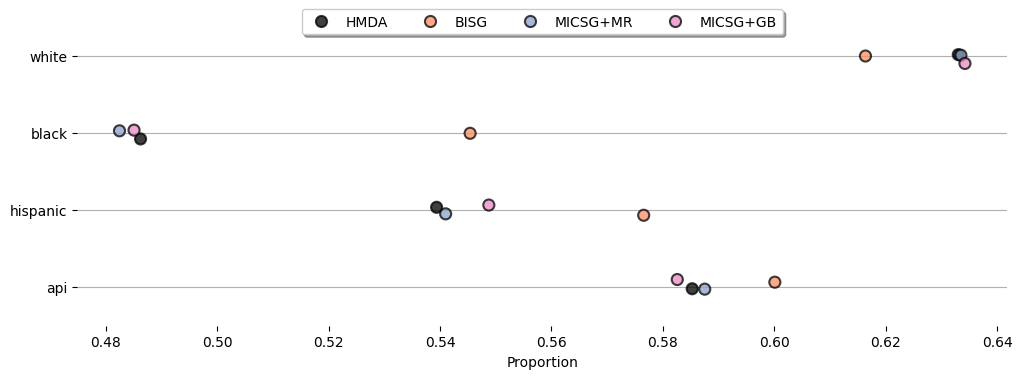

In [92]:
plt.figure(figsize=(12,4))
g = sns.stripplot(data=disp_df, 
              y="race", 
              x="prop.", 
              hue="method",
              linewidth=1.5,
              palette=colors,
              size=8,
              alpha=.75,
)

ax = plt.gca()
ax.yaxis.grid(True)
plt.ylabel("")
plt.xlabel("Proportion")

sns.despine(left=True, bottom=True)
plt.legend(loc="upper center", ncol=disp_df.method.unique().shape[0], fancybox=True, shadow=True, bbox_to_anchor=(0.5, 1.05))
plt.show()

TypeError: object of type 'Axes' has no len()

In [58]:
colors = sns.color_palette("Set2")
colors[0] = (0,0,0)
